# Gender and Finger Classification from Fingerprint Images

Fingerprint testing is a vast and extremely interesting topic. After all, each person has their own and unique. But is it possible to notice any patterns in them despite such unusualness? I decided to check it on the example of predicting the gender of the owner and a specific finger.

The SOCOFing dataset was used for the project. The SOCOFing dataset contains 6,000 fingerprints belonging to 600 African subjects.
There are 10 fingerprints per subject and all subjects are 18 years or older. SOCOFing
contains unique attributes such as labels for gender, hand and finger name. Moreover,
synthetically altered versions of these fingerprints are provided with three different levels of alteration for obliteration, central rotation, and z-cut.
(https://arxiv.org/abs/1807.10609)

In [ ]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Loading the dataset

Code below is designed to process image data in a specific format where the image filenames contain information about the gender, hand side, and finger. It extracts this information, assigns numerical values to them, and resizes the images for further use in a machine learning model.

In [ ]:
img_size = 96

def load_data(path, train=True):
    print("Loading data from:", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        img_info = imgname.split('__')
        ID = int(img_info[0]) - 1
        info = img_info[1].split('_')

        gender = info[0]
        lr = info[1]
        finger = info[2]

        # male or female subject
        genderNum = 0 if gender == "M" else 1
        # left or right hand
        base = 0 if lr == "Left" else 5

        # which finger it is
        finger_mapping = {"little": 0, "ring": 1, "middle": 2, "index": 3, "thumb": 4}
        fingerNum = base + finger_mapping[finger]

        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))

        data.append([genderNum, fingerNum, img_resize])

    return data

This code loads data from two different directories, representing altered and real fingerprint images. The data from the "Altered/Easy" directory is intended for training, while the data from the "Real" directory is likely for testing or validation purposes. The loaded data is stored in separate variables for further processing.

In [ ]:
Altered_path = "../input/socofing/SOCOFing/Altered/Altered-"
Real_path = "../input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
Real_data = load_data(Real_path, train=False)

Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from: ../input/socofing/SOCOFing/Real


# Preprocessing the data

Preprocess the loaded data by reshaping the features, normalizing the image values, and one-hot encoding the gender and finger labels.

In [ ]:
from sklearn.model_selection import train_test_split

X_Altered, y_genderNum_Altered, y_fingerNum_Altered = [], [], []

for genderNum, fingerNum, feature in Easy_data:
    X_Altered.append(feature)
    y_genderNum_Altered.append(genderNum)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]

y_genderNum_Altered = to_categorical(y_genderNum_Altered, num_classes=2)
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10)

# Splitting the data

Then, it splits the data into training and validation sets for gender and finger prediction tasks separately using the scikit-learn train_test_split function.

In [ ]:
X_genderNum_train, X_genderNum_val, y_genderNum_train, y_genderNum_val = train_test_split(
    X_Altered, y_genderNum_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

# Test set

The test data is prepared in the same format as the training and validation data to ensure compatibility with the model.

In [ ]:
X_test, y_genderNum_test, y_fingerNum_test = [], [], []

for genderNum, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_genderNum_test.append(genderNum)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_genderNum_test = to_categorical(y_genderNum_test, num_classes=2)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

# Verification

By printing the shapes of different data arrays and labels, this code provides an overview of the dataset's structure and dimensions for gender and finger prediction tasks. This way you can check whether a mistake has not been made in the previous steps.

In [ ]:
print("Shapes:                  Feature shape    Label shape")
print("----------------------------------------------------")
print("full genderNum data:  ", X_Altered.shape, y_genderNum_Altered.shape)
print("genderNum_Train:      ", X_genderNum_train.shape, y_genderNum_train.shape)
print("genderNum_Validation: ", X_genderNum_val.shape, y_genderNum_val.shape)
print("genderNum_Test:       ", X_test.shape, y_genderNum_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", X_Altered.shape, y_fingerNum_Altered.shape)
print("fingerNum_Train:      ", X_fingerNum_train.shape, y_fingerNum_train.shape)
print("fingerNum_Validation: ", X_fingerNum_val.shape, y_fingerNum_val.shape)
print("fingerNum_Test:       ", X_test.shape, y_fingerNum_test.shape)

Shapes:                  Feature shape    Label shape
----------------------------------------------------
full genderNum data:   (17931, 96, 96, 1) (17931, 2)
genderNum_Train:       (14344, 96, 96, 1) (14344, 2)
genderNum_Validation:  (3587, 96, 96, 1) (3587, 2)
genderNum_Test:        (6000, 96, 96, 1) (6000, 2)
----------------------------------------------------
full fingerNum data:   (17931, 96, 96, 1) (17931, 10)
fingerNum_Train:       (14344, 96, 96, 1) (14344, 10)
fingerNum_Validation:  (3587, 96, 96, 1) (3587, 10)
fingerNum_Test:        (6000, 96, 96, 1) (6000, 10)


# CNN model

Now, let's create 2 models with similar architectures but different final dense layers for gender and finger prediction. The models are compiled and ready to be trained on the respective datasets.

The model utilizes batch normalization to normalize the activations, which can help with training stability and generalization. Dropout is used to regularize the model and reduce overfitting. The model is trained using the Adam optimizer with a learning rate of 0.0001 and optimized for categorical cross-entropy loss.

In [ ]:
model = [0] * 2
final_Dense_units = [2, 10]
model_name = ['GenderNum_Mod', 'FingerNum_Mod']

for i in range(2):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "GenderNum_Mod"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       256       
 hNormalization)                                                 
                                                     

# Visualization

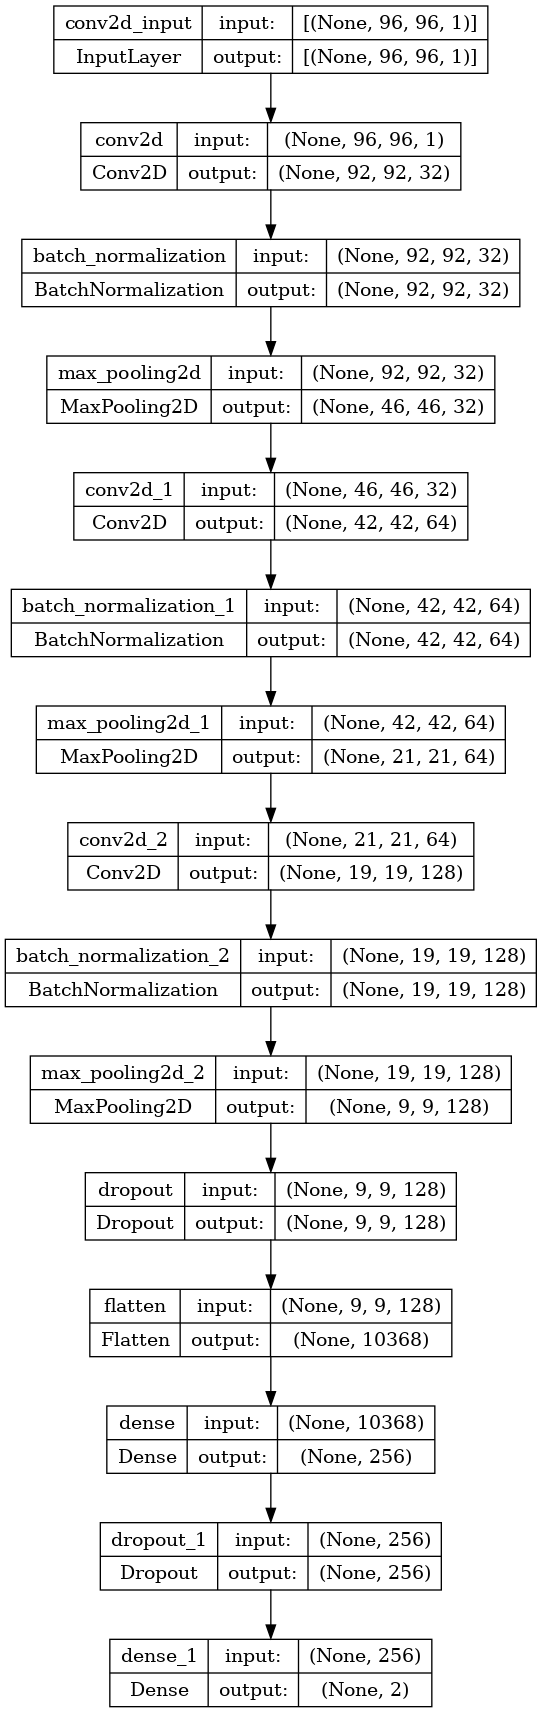

In [ ]:
plot_model(model[0], to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Training for gender

In [ ]:
history = [0] * 2
CallBack = [0] * 2
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64

In [ ]:
for i in range(2):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1),
        callbacks.TensorBoard(log_dir="./log_dir/"+model_name[i])]
history[0] = model[0].fit(X_genderNum_train, y_genderNum_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_genderNum_val, y_genderNum_val),
                    verbose = 1, callbacks= CallBack[0])

Epoch 1/20
225/225 [==============================] - 253s 1s/step - loss: 0.7244 - accuracy: 0.7816 - val_loss: 11.2718 - val_accuracy: 0.2057 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - 250s 1s/step - loss: 0.5467 - accuracy: 0.8189 - val_loss: 2.6922 - val_accuracy: 0.2456 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - 249s 1s/step - loss: 0.4997 - accuracy: 0.8419 - val_loss: 0.5701 - val_accuracy: 0.8199 - lr: 1.0000e-04
Epoch 4/20
225/225 [==============================] - 258s 1s/step - loss: 0.4249 - accuracy: 0.8753 - val_loss: 0.4541 - val_accuracy: 0.8726 - lr: 1.0000e-04
Epoch 5/20
225/225 [==============================] - 259s 1s/step - loss: 0.3484 - accuracy: 0.9113 - val_loss: 0.3495 - val_accuracy: 0.9144 - lr: 1.0000e-04
Epoch 6/20
225/225 [==============================] - 265s 1s/step - loss: 0.2734 - accuracy: 0.9427 - val_loss: 0.3371 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 7/20
225/225 [===================

Printing basic testing results:

In [ ]:
testing_results_gender = model[0].evaluate(X_test, y_genderNum_test, verbose=0)
testing_loss_gender = testing_results_gender[0]
testing_accuracy_gender = testing_results_gender[1]

print("Test loss: ", testing_loss_gender)
print("Test accuracy: ", testing_accuracy_gender)

Test loss:  0.13193832337856293
Test accuracy:  0.9965000152587891


# Training for finger

In [ ]:
history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Epoch 1/20
225/225 [==============================] - 258s 1s/step - loss: 2.0345 - accuracy: 0.3600 - val_loss: 5.0817 - val_accuracy: 0.1335 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - 253s 1s/step - loss: 1.4921 - accuracy: 0.5113 - val_loss: 2.0996 - val_accuracy: 0.3847 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - 254s 1s/step - loss: 1.2670 - accuracy: 0.5983 - val_loss: 1.1345 - val_accuracy: 0.6412 - lr: 1.0000e-04
Epoch 4/20
225/225 [==============================] - 257s 1s/step - loss: 1.0573 - accuracy: 0.6725 - val_loss: 0.9434 - val_accuracy: 0.7112 - lr: 1.0000e-04
Epoch 5/20
225/225 [==============================] - 254s 1s/step - loss: 0.8741 - accuracy: 0.7324 - val_loss: 0.7806 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 6/20
225/225 [==============================] - 253s 1s/step - loss: 0.7193 - accuracy: 0.7888 - val_loss: 0.6729 - val_accuracy: 0.8199 - lr: 1.0000e-04
Epoch 7/20
225/225 [====================

Printint basic testing results:

In [ ]:
testing_results_finger = model[1].evaluate(X_test, y_fingerNum_test, verbose=0)
testing_loss_finger = testing_results_finger[0]
testing_accuracy_finger = testing_results_finger[1]

print("Test loss: ", testing_loss_finger)
print("Test accuracy: ", testing_accuracy_finger)

Test loss:  0.15197968482971191
Test accuracy:  0.9940000176429749


# Training and validation loss and accuracy

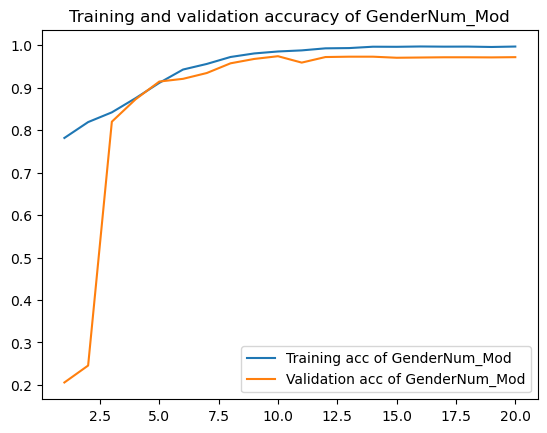

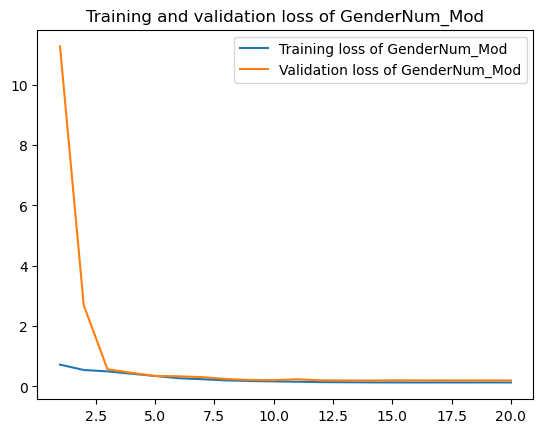

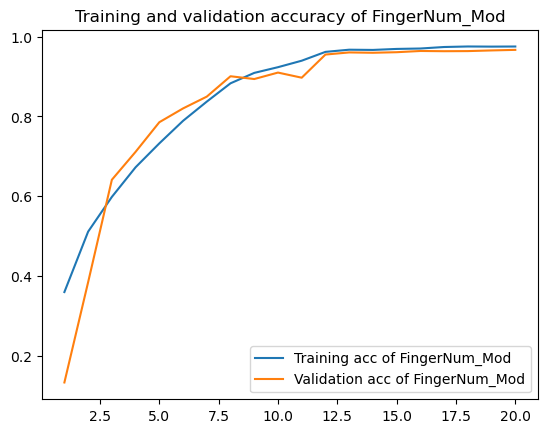

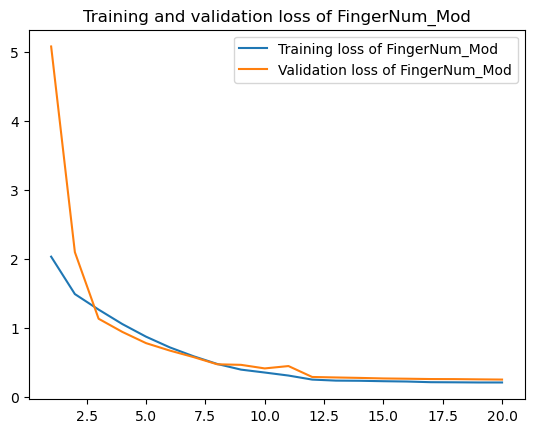

In [ ]:
acc = [0] * 2
val_acc = [0] * 2
loss = [0] * 2
val_loss = [0] * 2

for i in range(2):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

As you can see, everything went efficiently. Decreasing trend for loss and increasing trend for accuraccy in both models.

# Classification reports

In [ ]:
y_genderNum_pred = model[0].predict(X_test)
y_fingerNum_pred = model[1].predict(X_test)

y_genderNum_real = np.argmax(y_genderNum_test, axis=1)
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1)

y_genderNum_pred_classes = np.argmax(y_genderNum_pred, axis=1)
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1)

# Compute classification report
report_gender = classification_report(y_genderNum_real, y_genderNum_pred_classes)
report_finger = classification_report(y_fingerNum_real, y_fingerNum_pred_classes)

# Print the classification report
print("---------------------------------------")
print("Classification report (gender): ")
print(report_gender)
print("---------------------------------------")
print("Classification report (finger): ")
print(report_finger)

188/188 [==============================] - 24s 126ms/step
---------------------------------------
Classification report (gender): 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4770
           1       0.99      0.99      0.99      1230

    accuracy                           1.00      6000
   macro avg       1.00      0.99      0.99      6000
weighted avg       1.00      1.00      1.00      6000

---------------------------------------
Classification report (finger): 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       0.99      0.99      0.99       600
           2       1.00      0.99      0.99       600
           3       0.99      0.99      0.99       600
           4       1.00      1.00      1.00       600
           5       0.99      0.99      0.99       600
           6       1.00      0.99      0.99       600
           7       0.99      1.00   

Komentarz

# Confusion Matrix

In [ ]:
# Visualize finger prediction with confusion matrix
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx_gender = confusion_matrix(y_genderNum_real, y_genderNum_pred_classes)
confusion_mtx_finger = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes)

# Confusion matrix - gender

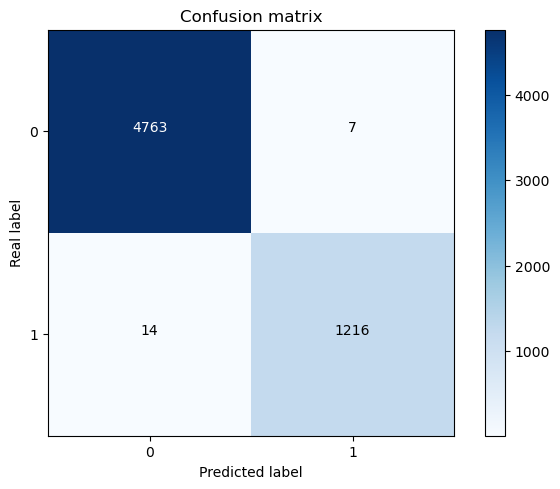

In [ ]:
plot_confusion_matrix(confusion_mtx_gender, classes = range(2))

# Confusion matrix - finger

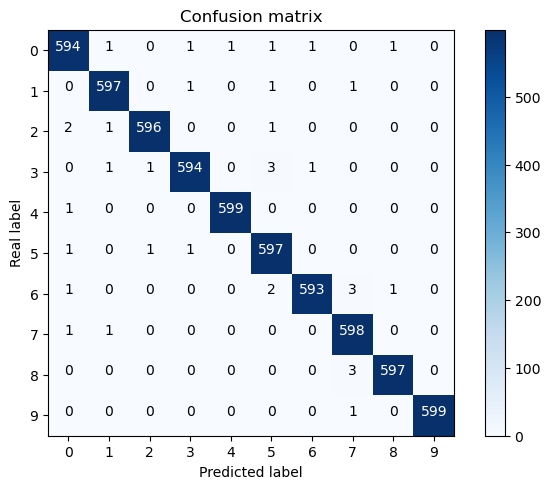

In [ ]:
plot_confusion_matrix(confusion_mtx_finger, classes = range(10))

In both cases, only single cases of bad matches can be observed.

# Prediction system

System displays a randomly selected fingerprint along with its predicted and real gender and finger labels, providing insights into the accuracy of the predictions. For the prediction to be correct, both attributes must match.

--------------------------------
Real gender:    Male
Predicted gender:  Male
Real finger:    Right Little
Predicted finger:  Right Little
--------------------------------
Prediction: Information confirmed.
--------------------------------
Randomly selected fingerprint:


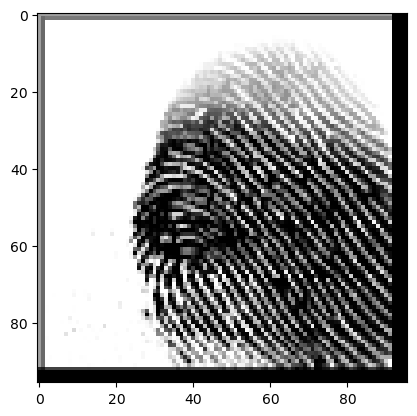

In [ ]:
def show_fingername(fingernum):
    if fingernum >= 5:
        fingername = "Right "
        fingernum -= 5
    else:
        fingername = "Left "
    if fingernum == 0:
        fingername += "Little"
    elif fingernum == 1:
        fingername += "Ring"
    elif fingernum == 2:
        fingername += "Middle"
    elif fingernum == 3:
        fingername += "Index"
    else:
        fingername += "Thumb"
    return fingername

def show_gendername(gendernum):
    if gendernum == 0:
        gendername = "Male"
    else:
        gendername = "Female"
    return gendername

# Randomly pick a fingerprint from test data to predict its gender and fingername
rand_fp_num = random.randint(0, X_test.shape[0] - 1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap='gray')
genderNum_pred = np.argmax(y_genderNum_pred[rand_fp_num])
genderNum_real = np.argmax(y_genderNum_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])

print("--------------------------------")
print("Real gender:   ", show_gendername(genderNum_real))
print("Predicted gender: ", show_gendername(genderNum_pred))
print("Real finger:   ", show_fingername(fingerNum_real))
print("Predicted finger: ", show_fingername(fingerNum_pred))
print("--------------------------------")

if fingerNum_pred == fingerNum_real and genderNum_pred == genderNum_real:
    print("Prediction: Information confirmed.")
else:
    print("Prediction: Incorrect.")
print("--------------------------------")
print("Randomly selected fingerprint:")


# Mispredicted instances

I also examined those that were misclassified. I haven't noticed a trend with any particular label. But you can definitely see that problems arise when the fingerprint is not fully visible or when the quality of image is really poor and it doesn’t allow the ridges to be detailed, sometimes they are not visible at all. Despite trying to improve it in some way, there are always some problematic ones left, but due to the fact that there are very few of them, I left it as it is.

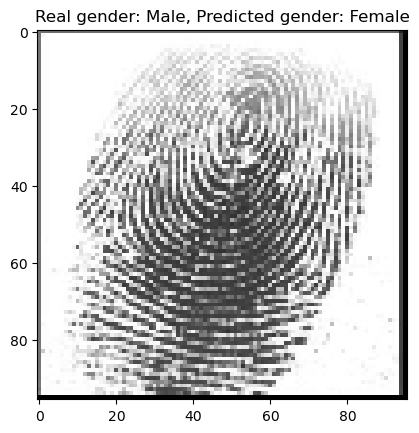

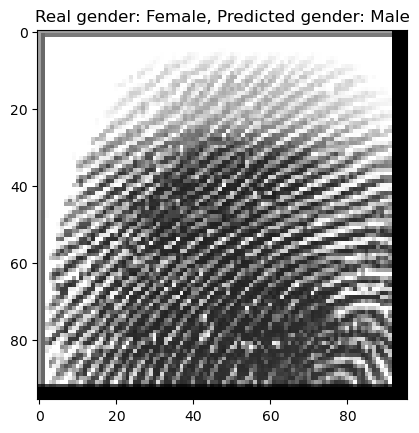

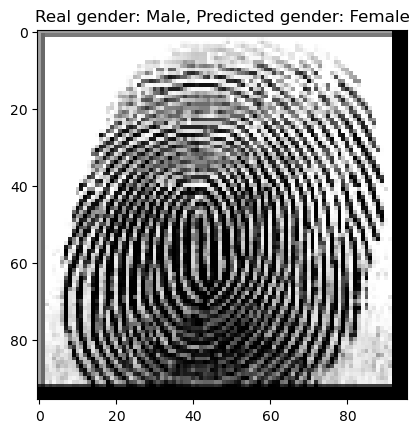

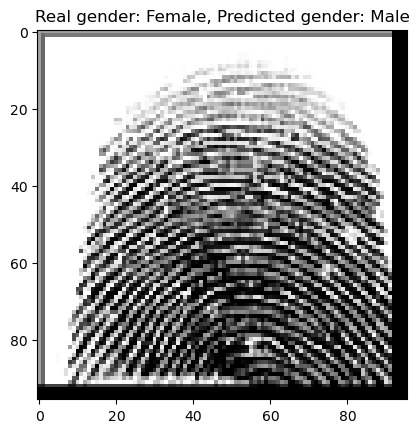

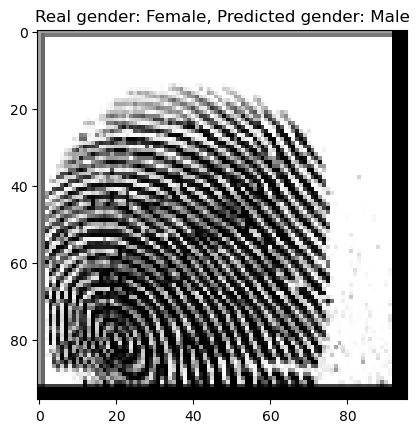

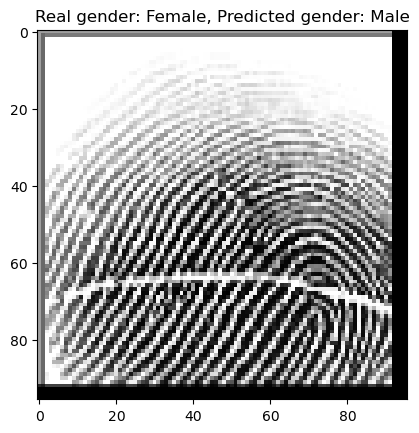

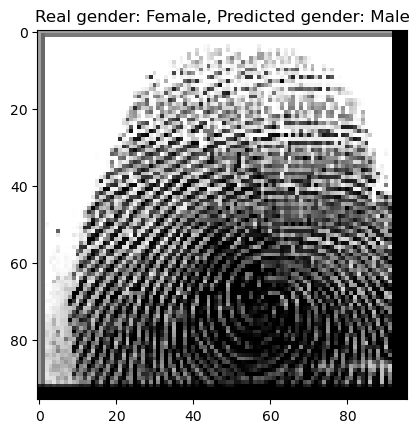

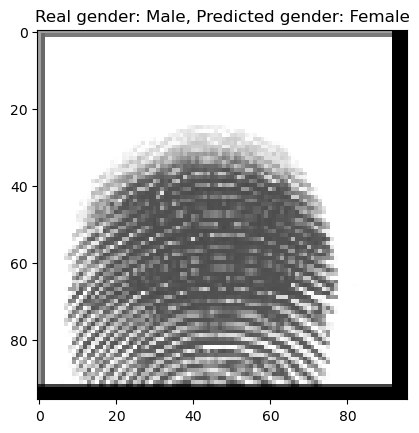

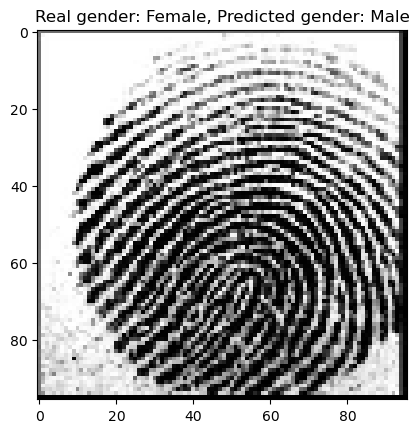

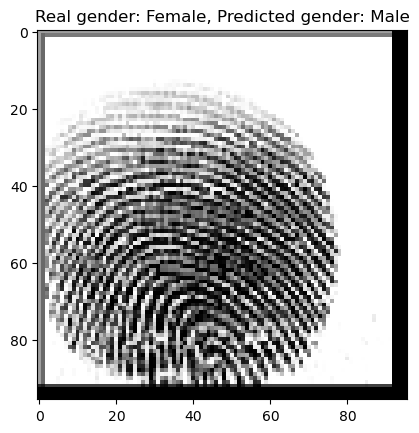

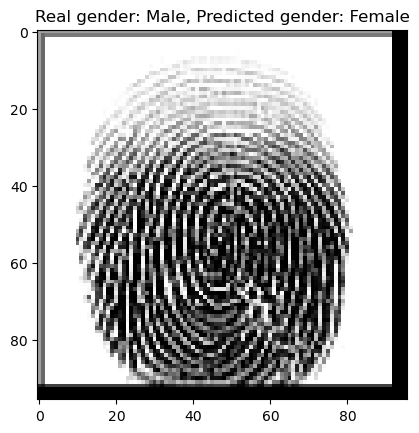

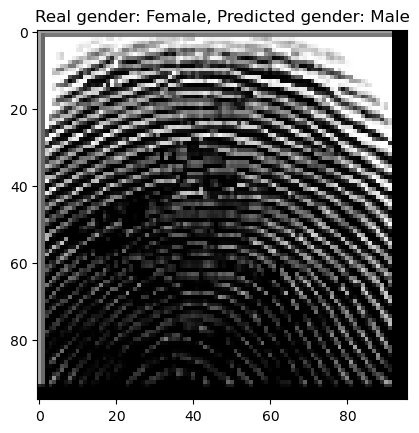

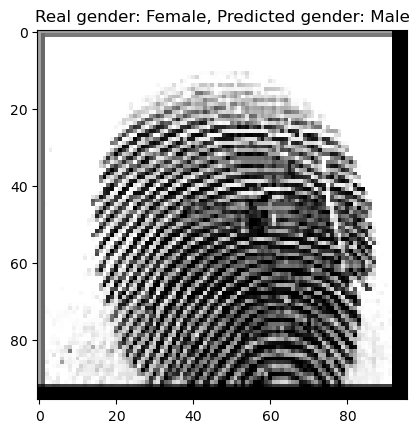

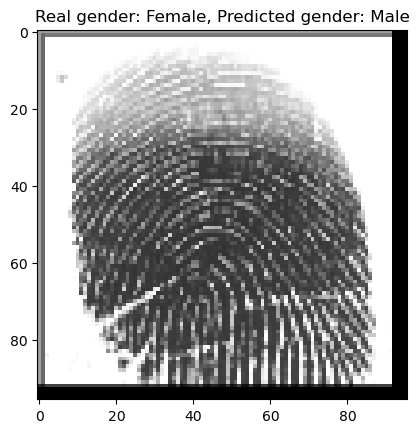

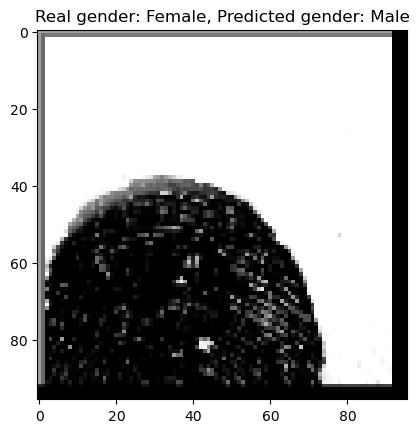

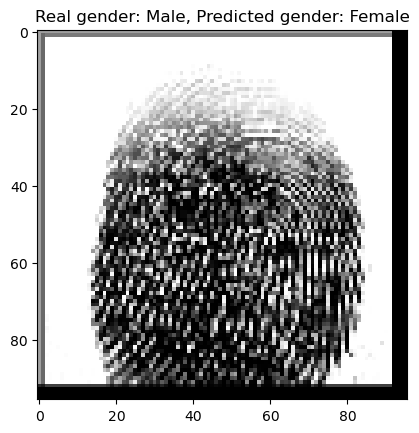

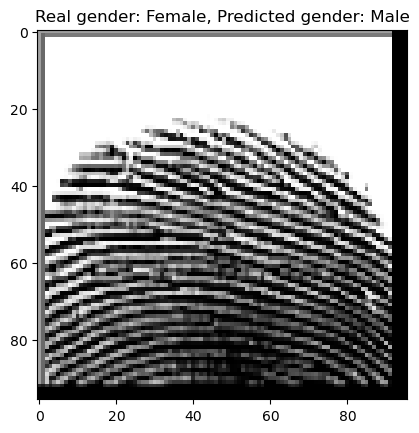

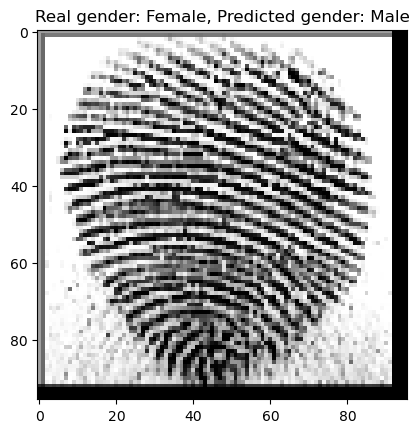

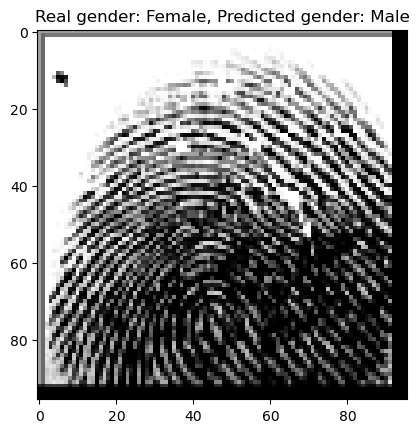

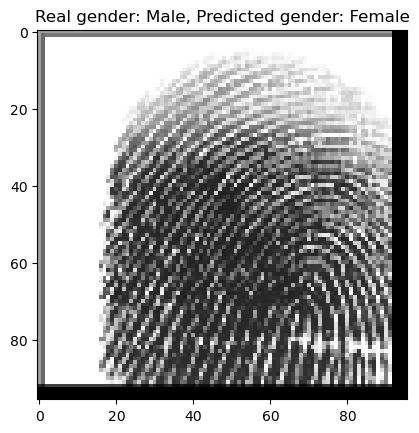

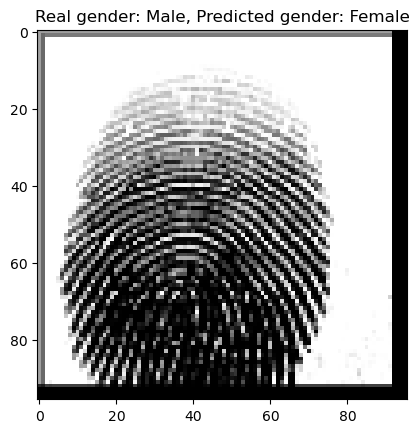

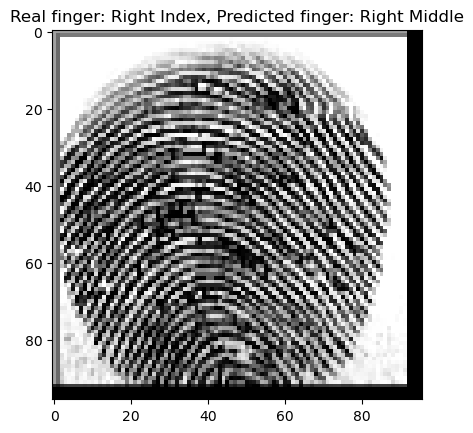

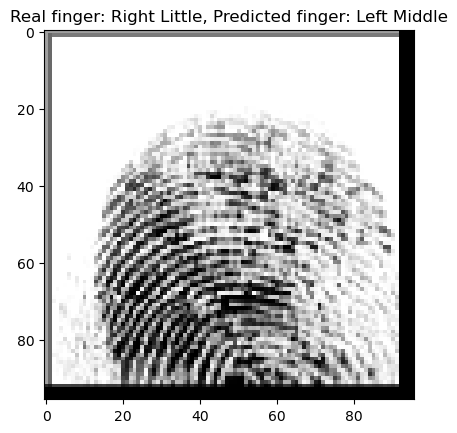

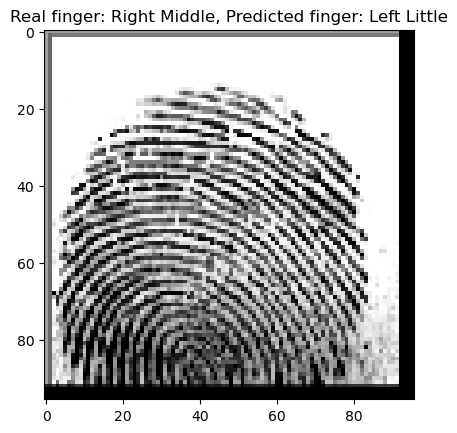

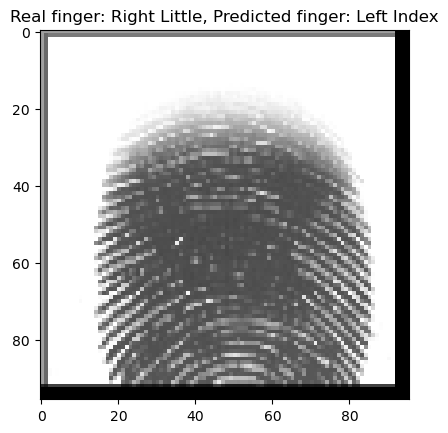

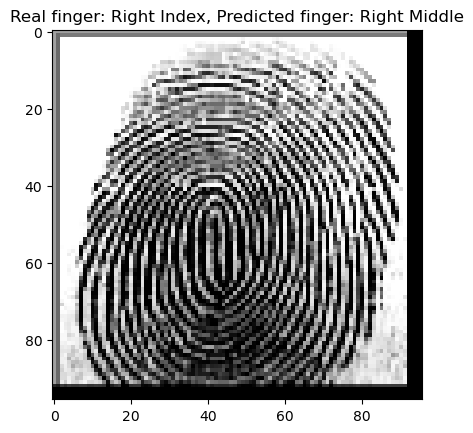

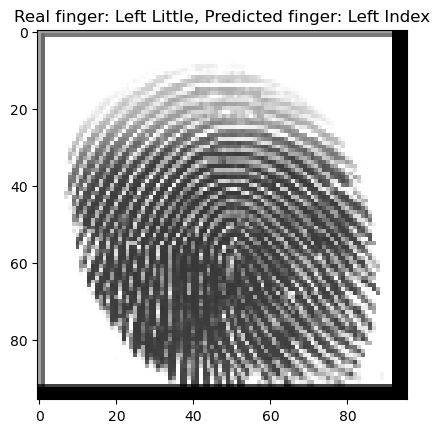

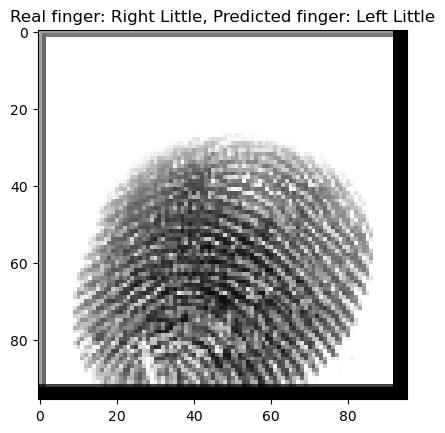

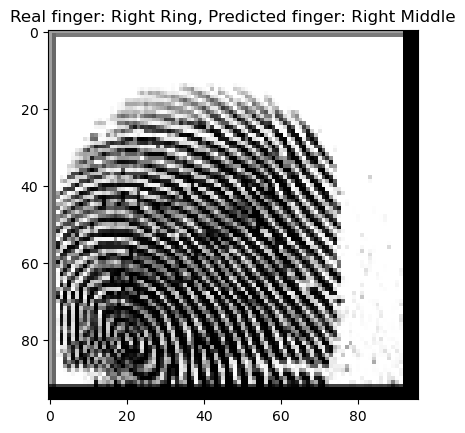

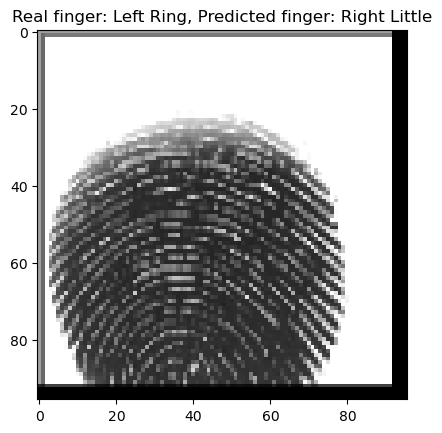

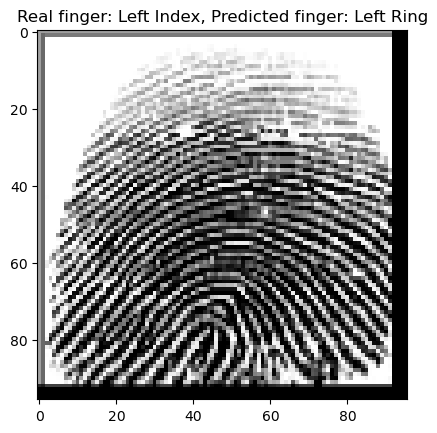

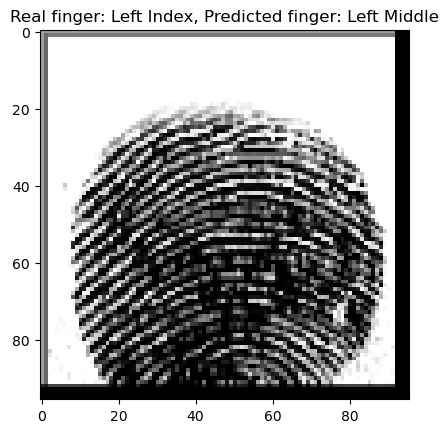

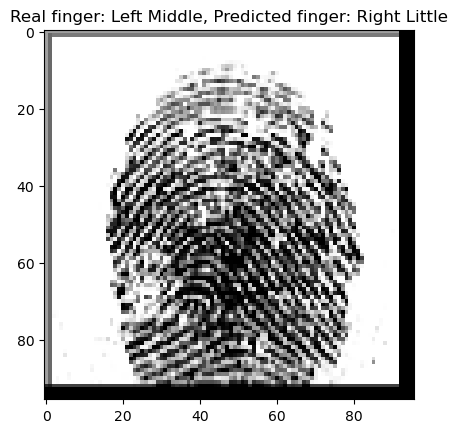

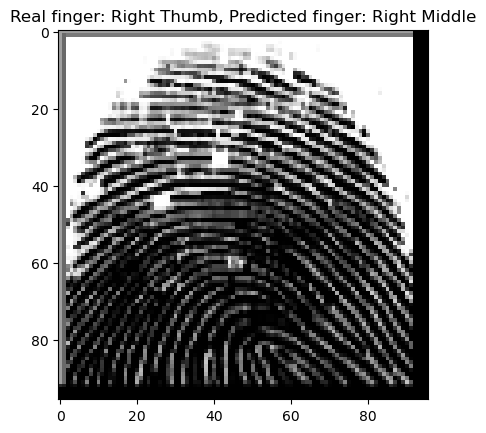

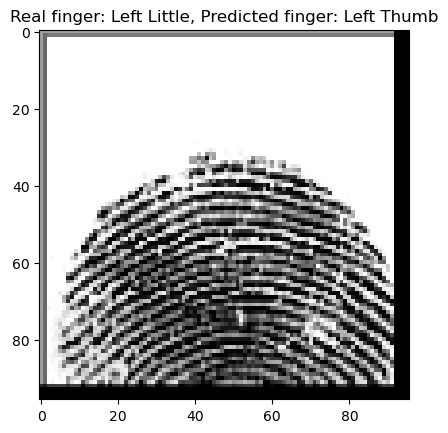

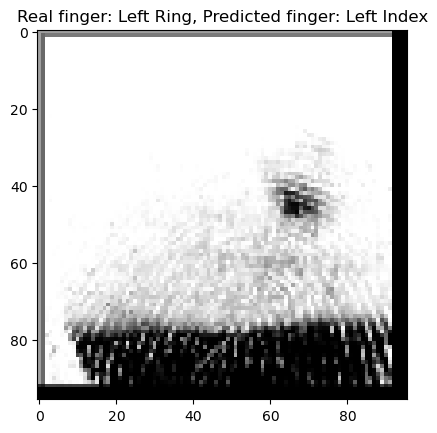

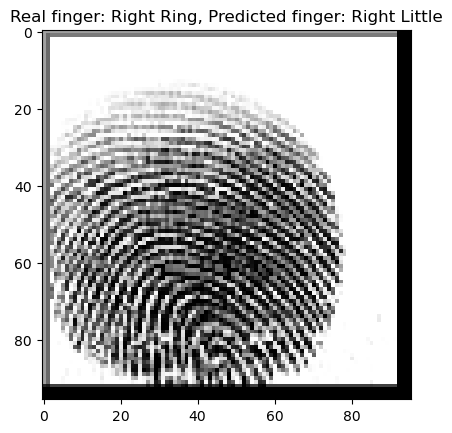

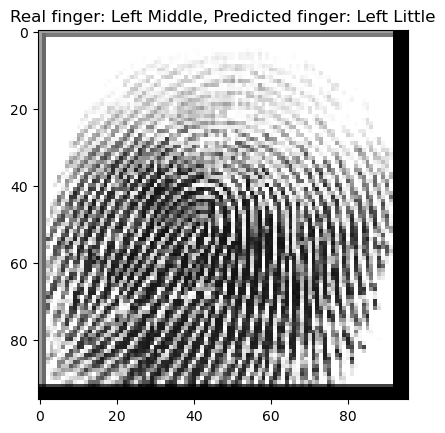

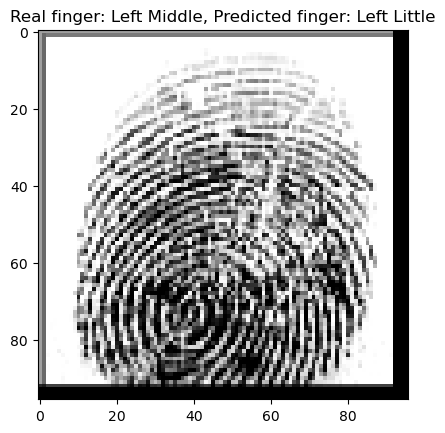

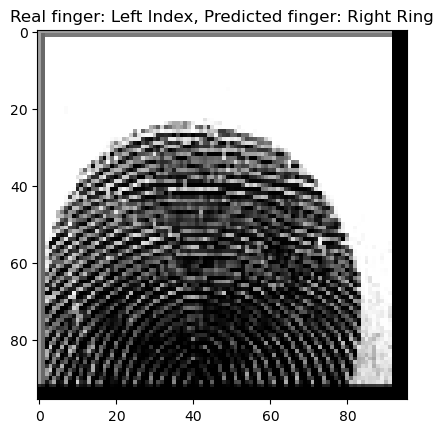

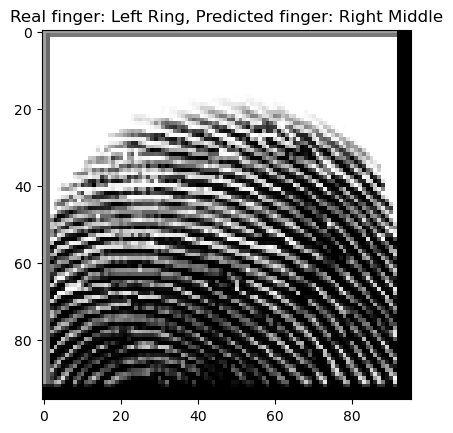

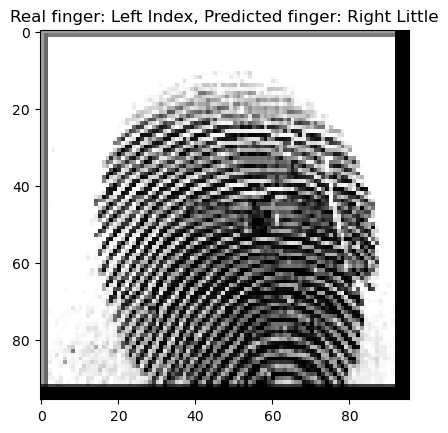

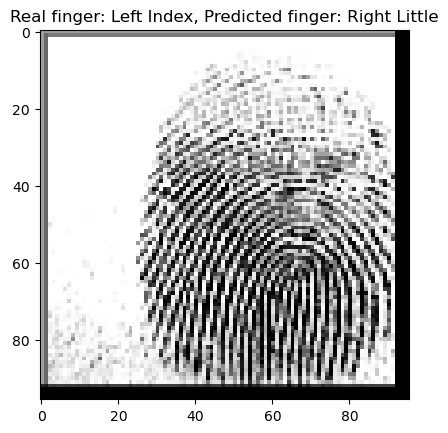

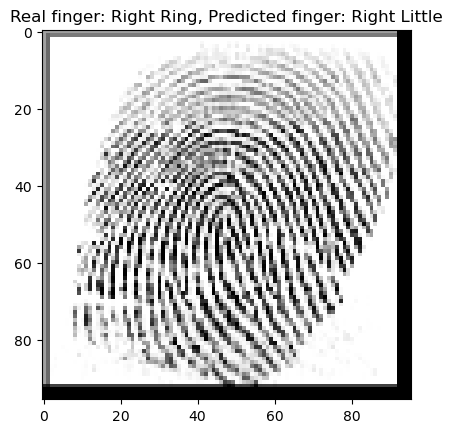

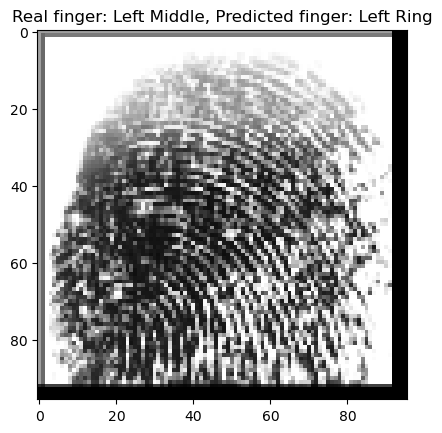

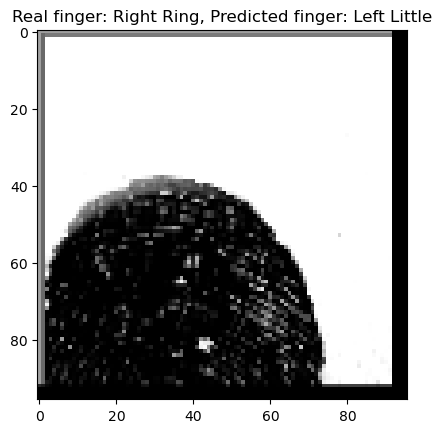

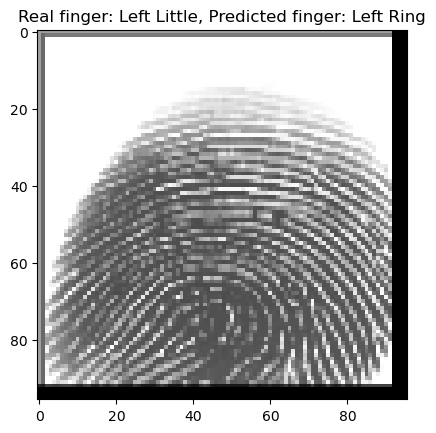

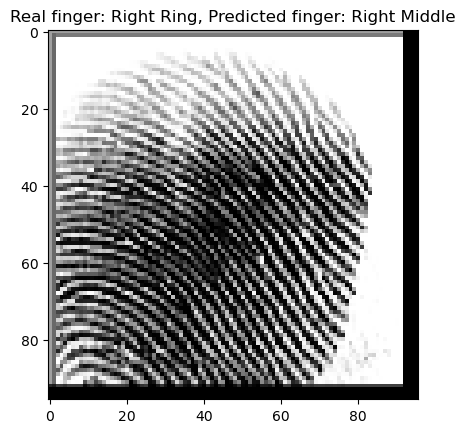

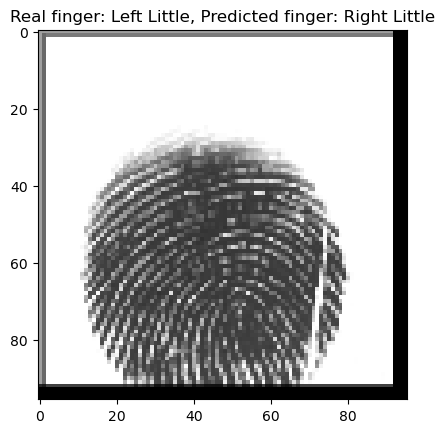

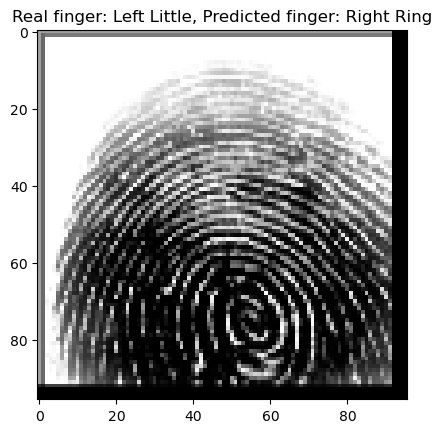

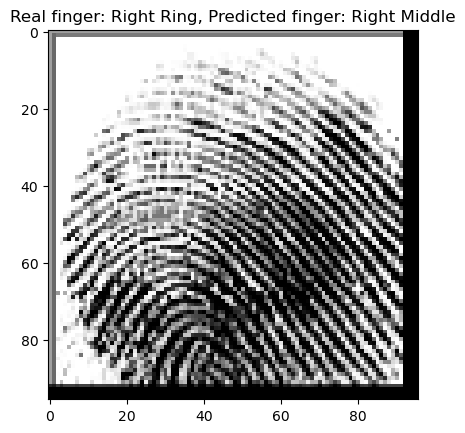

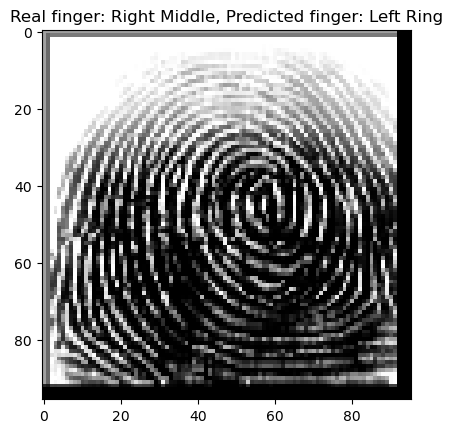

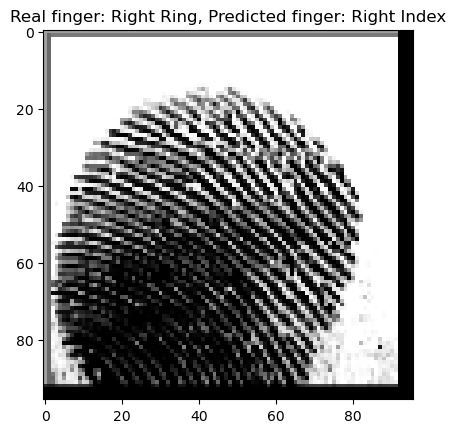

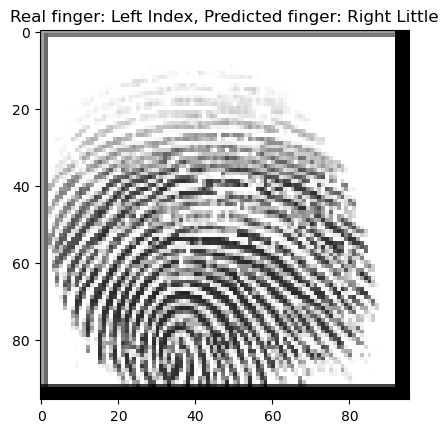

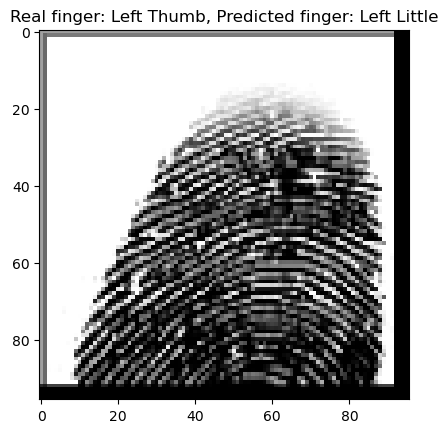

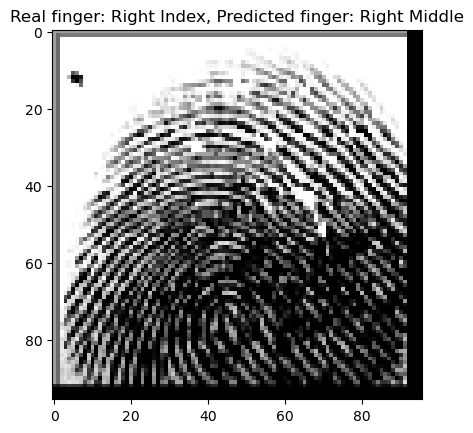

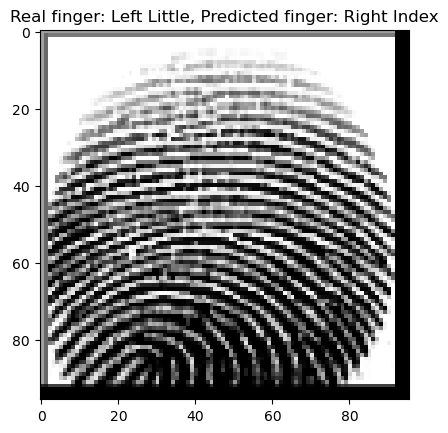

In [ ]:
# Get mispredicted instances
misgendered_indices = np.where(y_genderNum_pred_classes != y_genderNum_real)[0]
misfingered_indices = np.where(y_fingerNum_pred_classes != y_fingerNum_real)[0]

# Get mispredicted data
X_misgendered = X_test[misgendered_indices]
X_misfingered = X_test[misfingered_indices]

# Get mispredicted labels
y_genderNum_mispredicted = y_genderNum_pred_classes[misgendered_indices]
y_genderNum_real_mispredicted = y_genderNum_real[misgendered_indices]
y_fingerNum_mispredicted = y_fingerNum_pred_classes[misfingered_indices]
y_fingerNum_real_mispredicted = y_fingerNum_real[misfingered_indices]

# Visualize mispredicted instances
for i in range(len(X_misgendered)):
    plt.imshow(X_misgendered[i].reshape((96, 96)), cmap='gray')
    plt.title(f"Real gender: {show_gendername(y_genderNum_real_mispredicted[i])}, Predicted gender: {show_gendername(y_genderNum_mispredicted[i])}")
    plt.show()

for i in range(len(X_misfingered)):
    plt.imshow(X_misfingered[i].reshape((96, 96)), cmap='gray')
    plt.title(f"Real finger: {show_fingername(y_fingerNum_real_mispredicted[i])}, Predicted finger: {show_fingername(y_fingerNum_mispredicted[i])}")
    plt.show()

# Conclusion

To sum up, I think that despite the fact that the project ran smoothly, it was a challenge for me because at first I did not know what results I could get and how I should approach the subject.
I experimented a bit with different techniques that we learned during the semester in class and it allowed me to get satisfactory results.
The system works almost flawlessly, but this almost word is important in the context of using such systems in real life.
Because while in everyday devices a certain margin of error is allowed, there is no space for it in court cases, where someone’s guilt is decided. That's probably why they still rely on traditional methods.
And the deployment of such a system would require preparations and resources that the judicial system in Poland is unable to afford for now.